In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(1*u.km).to(u.cm)

<Quantity 100000. cm>

In [3]:
def signal(amp, sps, freq, phase, t):
    sig = amp*np.sin(2*np.pi*(freq/sps)*t + phase)
    return sig

In [4]:
#samples per second
sps = 1024
sigdur = 20 #seconds
t = np.arange(sps*sigdur)

In [5]:
input_freq = 4 #hertz
amp = 5 #units?
phi = np.pi/2 # radian phase shift
sig = signal(amp, sps, input_freq, phi, t)

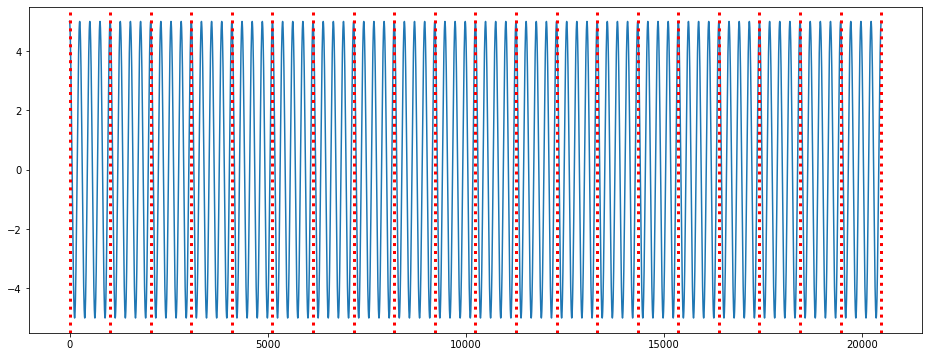

In [6]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot()
ax.plot(t,sig)
for i in range(0, sps*(sigdur+1), sps):
    ax.axvline(i, color='red', ls=':', lw=3)

In [7]:
fft_sig = np.fft.fft(sig)
fft_abs = np.abs(fft_sig[:len(fft_sig)//2])
max_pwr_i = fft_abs.argmax()
print(f'Max Power Index: {max_pwr_i}, Max Power: {fft_abs[max_pwr_i]}')


Max Power Index: 80, Max Power: 51200.0


In [8]:
n= len(sig)
timestep = 1/sps
freqs = np.fft.fftfreq(n, d=timestep)
print(f'Max Power Frequency: {freqs[max_pwr_i]}, Input Frequency: {input_freq}')
print(f'Amplitude: {2*fft_abs[max_pwr_i]/len(sig)}')
print(f'Phase: {np.angle(fft_sig[max_pwr_i])+np.pi/2}')

Max Power Frequency: 4.0, Input Frequency: 4
Amplitude: 5.0
Phase: 1.5707963267948821


In [9]:
fft_sig[max_pwr_i]

(51200-7.334612319059567e-10j)

In [10]:
-np.pi/2

-1.5707963267948966

In [11]:
# n: length of signal (number of samples)
# d: cycles per unit of sample spacing = 1/samples_per_second => seconds per sample
# d*n number of seconds in signal
# range(0,n/2)/(d*n) => frequency at each fft bin
freq_test = np.arange(len(sig)//2)/(n/sps)
freq_test[max_pwr_i]

4.0

In [12]:
help(np.fft.fftfreq)

Help on function fftfreq in module numpy.fft:

fftfreq(n, d=1.0)
    Return the Discrete Fourier Transform sample frequencies.
    
    The returned float array `f` contains the frequency bin centers in cycles
    per unit of the sample spacing (with zero at the start).  For instance, if
    the sample spacing is in seconds, then the frequency unit is cycles/second.
    
    Given a window length `n` and a sample spacing `d`::
    
      f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
      f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd
    
    Parameters
    ----------
    n : int
        Window length.
    d : scalar, optional
        Sample spacing (inverse of the sampling rate). Defaults to 1.
    
    Returns
    -------
    f : ndarray
        Array of length `n` containing the sample frequencies.
    
    Examples
    --------
    >>> signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
    >>> fourier = np.fft.fft(signal)
    >>> n = 

## Fit using Least Squares

In [13]:
from scipy.optimize import minimize

In [14]:
#def signal(amp, sps, freq, phase, t):

def sse(params, y, sps, t):
    #print(f'len(y): {len(y)}, len(t): {len(t)}')
    amp = params[0]
    freq = params[1]
    phase = params[2]
    yhat = signal(amp, sps, freq, phase, t)

    e = ((y-yhat)**2).sum()
    
    return e


In [15]:
#init_params = np.array([amp*0.75, input_freq, phi] )
init_params = np.array([amp,input_freq*1.5,phi])
iter_no = 0
params = minimize(sse, init_params, (sig, sps, t), bounds = [(0, 100),(0, 100), (-np.pi/2, np.pi/2)])
params

      fun: 256000.0
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0., -0., -0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([  0.        , 100.        ,   1.57079633])

(0.0, 2048.0)

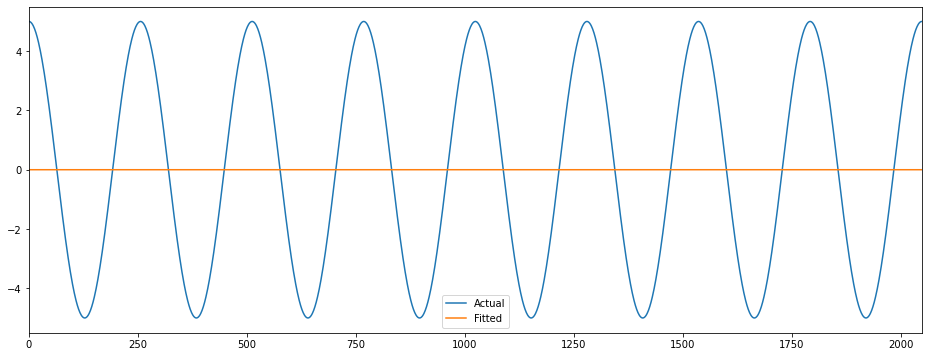

In [16]:
sig_hat = signal(params['x'][0], sps, params['x'][1], params['x'][2],t )
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot()
ax.plot(t,sig, label='Actual')
ax.plot(t,sig_hat, label='Fitted')
ax.legend()
ax.set_xlim(0,2*sps)


Want plot that shows sse over a grid. x-axis is frequency, y-axis is amplitude.  In the array, the low order dimension is the x-axis, so we'll need a different frequency for each bin in the frequency range -- a different value for each __column__.

In [17]:
freq_rng = np.linspace(1,12, 1000) #x-axis (columns)
amp_rng = np.linspace(1,10, 1000) #y-axis (rows)

In [18]:
FREQS, AMPS = np.meshgrid(freq_rng, amp_rng)
FREQS.shape, AMPS.shape

((1000, 1000), (1000, 1000))

Which is as it should be: 500 rows for the y axis and 1000 columns for the x axis

In [19]:
#def sse(params, y, sps, t)
all_sse = np.array([sse((a,f, phi), sig, sps, t) for a,f in zip(AMPS.flatten(),FREQS.flatten())]).reshape(len(amp_rng), len(freq_rng))


In [20]:
all_sse.shape

(1000, 1000)

(3.95, 4.05)

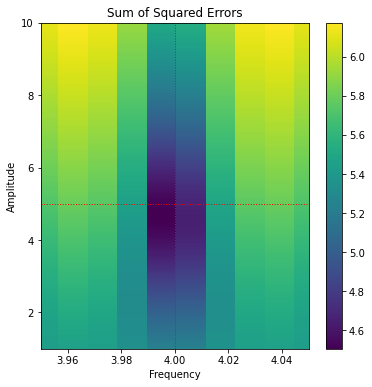

In [21]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
pcm=ax.pcolormesh(freq_rng, amp_rng, np.log10(all_sse), shading='auto')
ax.axhline(amp, color='red', ls=':', lw=1)
ax.axvline(input_freq, color='red', ls=':',lw=1)
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')
ax.set_title('Sum of Squared Errors')
fig.colorbar(pcm)
ax.set_xlim(3.95,4.05)
#ax.set_ylim(4.5,5.5)

(3.0, 5.0)

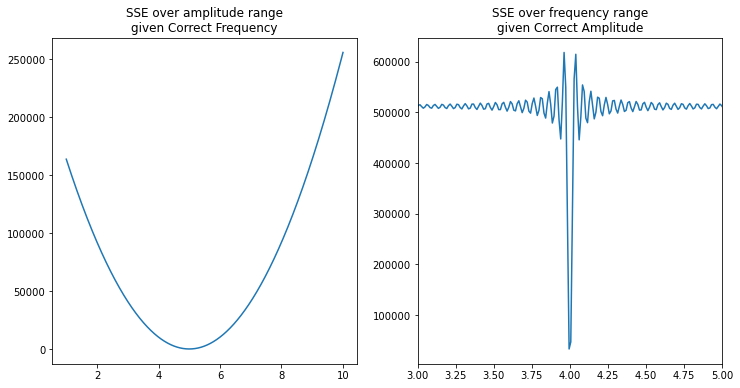

In [22]:
fig = plt.figure(figsize=(12,6))
axs = fig.subplots(1,2)
ax = axs[0]

sse_amp = np.array([sse((a,input_freq, phi), sig, sps, t) for a in amp_rng])

ax.plot(amp_rng, sse_amp)
ax.set_title('SSE over amplitude range\ngiven Correct Frequency')
sse_freq = np.array([sse((amp,f, phi), sig, sps, t) for f in freq_rng])
ax = axs[1]
ax.plot(freq_rng, sse_freq)
ax.set_title('SSE over frequency range\ngiven Correct Amplitude')
ax.set_xlim(3.0, 5.0)


In [23]:
sse((amp, input_freq, phi), sig, sps, t)

0.0

In [24]:
n= len(sig)
timestep = 1/sps
freqs = np.fft.fftfreq(n, d=timestep)
print(f'Max Power Frequency: {freqs[max_pwr_i]}, Input Frequency: {input_freq}')
print(f'Amplitude: {2*fft_abs[max_pwr_i]/len(sig)}')
print(f'Phase: {np.angle(fft_sig[max_pwr_i])+np.pi/2}')

Max Power Frequency: 4.0, Input Frequency: 4
Amplitude: 5.0
Phase: 1.5707963267948821


In [25]:
def analyze_signal(sig, sample_rate, n_components):
    n = len(sig)
    sig_fft = np.fft.fft(sig)
    freqs = np.fft.fftfreq(n, 1/sample_rate)
    fft_abs = np.abs(sig_fft)
    bias = fft_abs[0]/n
    fft_abs[0] = 0
    fft_abs = fft_abs[:n//2]
    power_i = np.flip(np.argsort(fft_abs))[:n_components]

    res = {'Bias': bias,
           'Amplitude':np.zeros(n_components),
           'Frequency':np.zeros(n_components),
           'Phase': np.zeros(n_components) }
    
    for i in range(n_components):
        pi = power_i[i]
        res['Amplitude'][i] = 2*fft_abs[pi]/n
        res['Frequency'][i] = freqs[pi]
        res['Phase'][i] = np.angle(sig_fft[pi]) + np.pi/2
    
    return res


In [26]:
analyze_signal(sig, sps, 1)

{'Bias': 5.780598737824881e-16,
 'Amplitude': array([5.]),
 'Frequency': array([4.]),
 'Phase': array([1.57079633])}

In [27]:
np.random.seed(1234)
sig2 = 38+signal(4, sps, 6, 0, t) + signal(2.2, sps, 11, np.pi/4, t)+ np.random.randn(len(t))

(0.0, 2048.0)

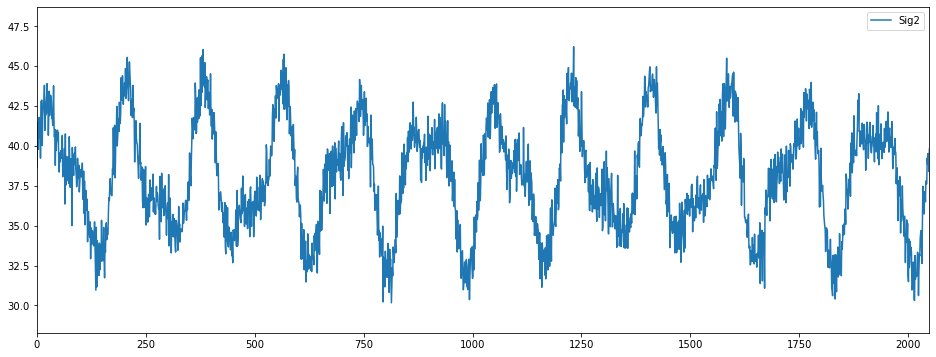

In [28]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot()
ax.plot(t,sig2, label='Sig2')
ax.legend()
ax.set_xlim(0,2*sps)


In [29]:
analyze_signal(sig2, sps, 2)

{'Bias': 38.007013773525365,
 'Amplitude': array([3.98406666, 2.18572578]),
 'Frequency': array([ 6., 11.]),
 'Phase': array([-0.00250031,  0.78253171])}

In [30]:
sig_b = 25 + sig

In [31]:
sig_b_fft = np.fft.fft(sig_b)


In [32]:
np.abs(sig_b_fft[0])/len(sig_b_fft)

25.0

In [33]:
all_sse[ 500, 247]

575401.0347524668

In [34]:
FREQS[247,495:505]-input_freq, AMPS[245:255, 500]-amp

(array([2.45045045, 2.46146146, 2.47247247, 2.48348348, 2.49449449,
        2.50550551, 2.51651652, 2.52752753, 2.53853854, 2.54954955]),
 array([-1.79279279, -1.78378378, -1.77477477, -1.76576577, -1.75675676,
        -1.74774775, -1.73873874, -1.72972973, -1.72072072, -1.71171171]))